In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
from circuit_partition import *

In [2]:
os.makedirs("plots", exist_ok=True)

In [3]:
d = 4
k = 3
measure_qubits_ord_dxd = get_measure_qubits_ord(d)
data_qubits_ord_dxd = get_data_qubits_ord(d)
measure_qubits_ord_kxk = get_measure_qubits_ord(k)
data_qubits_ord_kxk = get_data_qubits_ord(k)

In [4]:
# Plot the dxd array

def plot_qubits(data, measure, d, kernels = [], point_size = 400, save = None):
  arr_data = []
  arr_measure_Z = []
  arr_measure_X = []

  for q in data:
    coords = q[2]
    x = coords[0]
    y = 2*d - coords[1]
    arr_data.append([x, y])
  for q in measure:
    coords = q[2]
    x = coords[0]
    y = 2*d - coords[1]
    lbl = q[1]
    if lbl=="M:Z":
      arr_measure_Z.append([x, y])
    else:
      arr_measure_X.append([x, y])

  arr_data = np.array(arr_data)
  arr_measure_Z = np.array(arr_measure_Z)
  arr_measure_X = np.array(arr_measure_X)

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.scatter(arr_data[:,0], arr_data[:,1], label='Data qubits', s=point_size, marker='o', facecolors='none', edgecolors='black')
  ax.scatter(arr_data[:,0], arr_data[:,1], s=point_size, marker='o', facecolors='gray', edgecolors='black', alpha=0.5)
  ax.scatter(arr_measure_Z[:,0], arr_measure_Z[:,1], label='Measure Z', s=point_size, marker='o', facecolors='orange', edgecolors='orange', alpha=0.5)
  ax.scatter(arr_measure_X[:,0], arr_measure_X[:,1], label='Measure X', s=point_size, marker='o', facecolors='blue', edgecolors='blue', alpha=0.5)
  for iq in range(arr_measure_Z.shape[0]):
    ax.text(arr_measure_Z[iq, 0], arr_measure_Z[iq, 1], 'Z', fontsize=12, color='black', ha='center', va='center')
  for iq in range(arr_measure_X.shape[0]):
    ax.text(arr_measure_X[iq, 0], arr_measure_X[iq, 1], 'X', fontsize=12, color='black', ha='center', va='center')
  for iq in range(arr_data.shape[0]):
    ax.text(arr_data[iq, 0], arr_data[iq, 1], 'D', fontsize=12, color='black', ha='center', va='center')

  # Draw an envelope that encloses kernel_data nad kernel_measure qubits, which are a subset of data and measure qubits already drawn
  for kernel in kernels:
    kernel_data = kernel['data']
    kernel_measure = kernel['measure']
    kernel_color = kernel['color']
    kernel_alpha = (0.45 if 'alpha' not in kernel else kernel['alpha'])
    kernel_offset = ([0.,0.] if 'offset' not in kernel else kernel['offset'])
    arr_kernel = []
    for q in kernel_data:
      coords = q[2]
      x = coords[0]
      y = 2*d - coords[1]
      arr_kernel.append([x, y])
    for q in kernel_measure:
      coords = q[2]
      x = coords[0]
      y = 2*d - coords[1]
      arr_kernel.append([x, y])
    arr_kernel = np.array(arr_kernel, dtype=np.float64)
    arr_kernel[:,0] += kernel_offset[0]
    arr_kernel[:,1] += kernel_offset[1]
    # Make a set of lines that enclose the outer edges of the kernel data or measure qubits
    for iq in range(arr_kernel.shape[0]):
      for iedge in range(4):
        if iedge==0: # Top edge
          nodraw = False
          boundn = 0
          for jq in range(arr_kernel.shape[0]):
            if np.abs(arr_kernel[jq][0]-arr_kernel[iq][0])==1 and arr_kernel[jq][1]-arr_kernel[iq][1]==1:
              boundn += 1
            if arr_kernel[jq][0]!=arr_kernel[iq][0]:
              continue
            if arr_kernel[jq][1]>arr_kernel[iq][1]:
              nodraw = True
              break
          offset = 0
          if boundn==2:
            offset = 1
          if not nodraw:
            ax.plot([arr_kernel[iq][0]-0.5, arr_kernel[iq][0]+0.5], [arr_kernel[iq][1]+0.5+offset, arr_kernel[iq][1]+0.5+offset], color=kernel_color, linestyle='--', linewidth=4, alpha=kernel_alpha)
        elif iedge==1: # Bottom edge
          nodraw = False
          boundn = 0
          for jq in range(arr_kernel.shape[0]):
            if np.abs(arr_kernel[jq][0]-arr_kernel[iq][0])==1 and arr_kernel[jq][1]-arr_kernel[iq][1]==-1:
              boundn += 1
            if arr_kernel[jq][0]!=arr_kernel[iq][0]:
              continue
            if arr_kernel[jq][1]<arr_kernel[iq][1]:
              nodraw = True
              break
          offset = 0
          if boundn==2:
            offset = 1
          if not nodraw:
            ax.plot([arr_kernel[iq][0]-0.5, arr_kernel[iq][0]+0.5], [arr_kernel[iq][1]-0.5-offset, arr_kernel[iq][1]-0.5-offset], color=kernel_color, linestyle='--', linewidth=4, alpha=kernel_alpha)
        elif iedge==2: # Left edge
          nodraw = False
          boundn = 0
          for jq in range(arr_kernel.shape[0]):
            if np.abs(arr_kernel[jq][1]-arr_kernel[iq][1])==1 and arr_kernel[jq][0]-arr_kernel[iq][0]==-1:
              boundn += 1
            if arr_kernel[jq][1]!=arr_kernel[iq][1]:
              continue
            if arr_kernel[jq][0]<arr_kernel[iq][0]:
              nodraw = True
              break
          offset = 0
          if boundn==2:
            offset = 1
          if not nodraw:
            ax.plot([arr_kernel[iq][0]-0.5-offset, arr_kernel[iq][0]-0.5-offset], [arr_kernel[iq][1]-0.5, arr_kernel[iq][1]+0.5], color=kernel_color, linestyle='--', linewidth=4, alpha=kernel_alpha)
        elif iedge==3: # Right edge
          nodraw = False
          boundn = 0
          for jq in range(arr_kernel.shape[0]):
            if np.abs(arr_kernel[jq][1]-arr_kernel[iq][1])==1 and arr_kernel[jq][0]-arr_kernel[iq][0]==1:
              boundn += 1
            if arr_kernel[jq][1]!=arr_kernel[iq][1]:
              continue
            if arr_kernel[jq][0]>arr_kernel[iq][0]:
              nodraw = True
              break
          offset = 0
          if boundn==2:
            offset = 1
          if not nodraw:
            ax.plot([arr_kernel[iq][0]+0.5+offset, arr_kernel[iq][0]+0.5+offset], [arr_kernel[iq][1]-0.5, arr_kernel[iq][1]+0.5], color=kernel_color, linestyle='--', linewidth=4, alpha=kernel_alpha)

  # Remove axis labels
  ax.set_xticks([])
  ax.set_yticks([])
  #ax.legend()
  fig.set_dpi(120)
  plt.grid(False)
  if save is not None:
    plt.axis('off')
  plt.show()
  if save is not None:
    fig.savefig('plots/' + save, bbox_inches="tight")

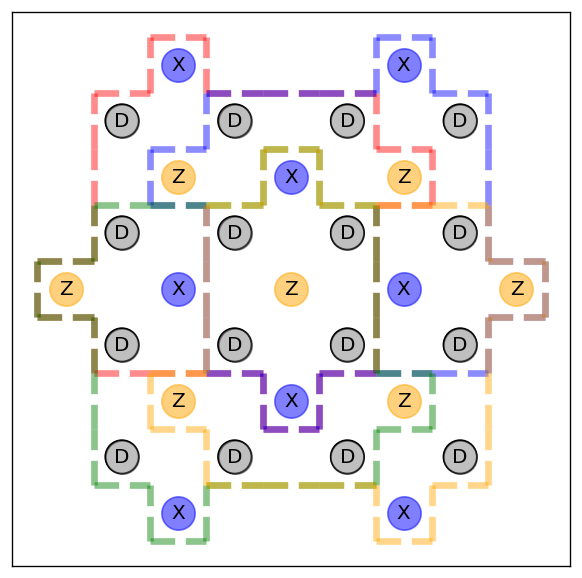

In [5]:
shifted_data_kxk_TL, shifted_measure_kxk_TL = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 0, 0)
shifted_data_kxk_TR, shifted_measure_kxk_TR = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 0)
shifted_data_kxk_BL, shifted_measure_kxk_BL = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 0, 1)
shifted_data_kxk_BR, shifted_measure_kxk_BR = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 1)


plot_qubits(
  data_qubits_ord_dxd, measure_qubits_ord_dxd, d, 
  [
    {'data' : shifted_data_kxk_TL, 'measure' : shifted_measure_kxk_TL, 'color' : 'red'},
    {'data' : shifted_data_kxk_TR, 'measure' : shifted_measure_kxk_TR, 'color' : 'blue'},
    {'data' : shifted_data_kxk_BL, 'measure' : shifted_measure_kxk_BL, 'color' : 'green'},
    {'data' : shifted_data_kxk_BR, 'measure' : shifted_measure_kxk_BR, 'color' : 'orange'}
  ]
)

In [6]:
d = 9
measure_qubits_ord_dxd = get_measure_qubits_ord(d)
data_qubits_ord_dxd = get_data_qubits_ord(d)

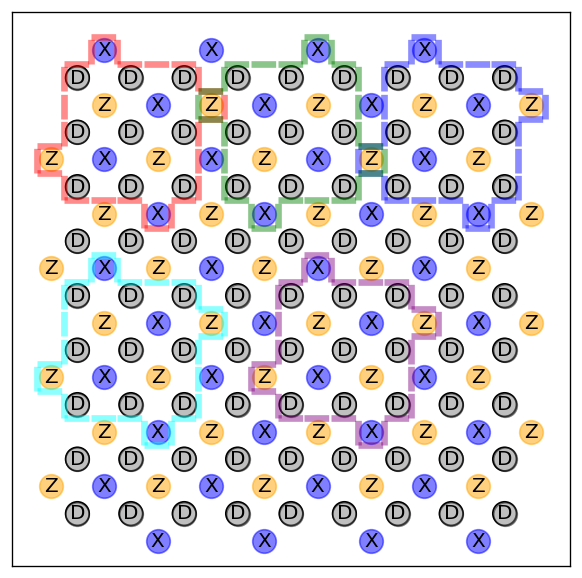

In [7]:
kernels5=[]

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 0, 0)
kernels5.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'red'})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 6, 0)
kernels5.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'blue'})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 3, 0)
kernels5.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'green'})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 0, 4)
kernels5.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'cyan'})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 4, 4)
kernels5.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'purple'})

plot_qubits(
  data_qubits_ord_dxd, measure_qubits_ord_dxd, d, kernels5, point_size = 200
)

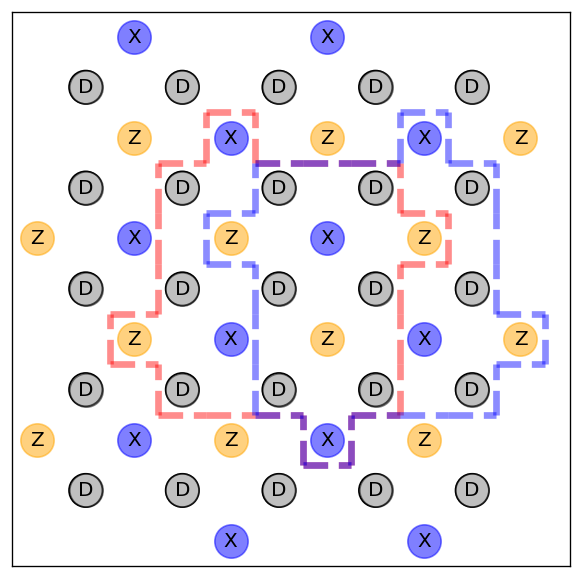

In [8]:
d = 5
measure_qubits_ord_dxd = get_measure_qubits_ord(d)
data_qubits_ord_dxd = get_data_qubits_ord(d)

kernels=[]

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 1)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'red'})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 2, 1)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'blue'})

plot_qubits(
  data_qubits_ord_dxd, measure_qubits_ord_dxd, d, kernels
)

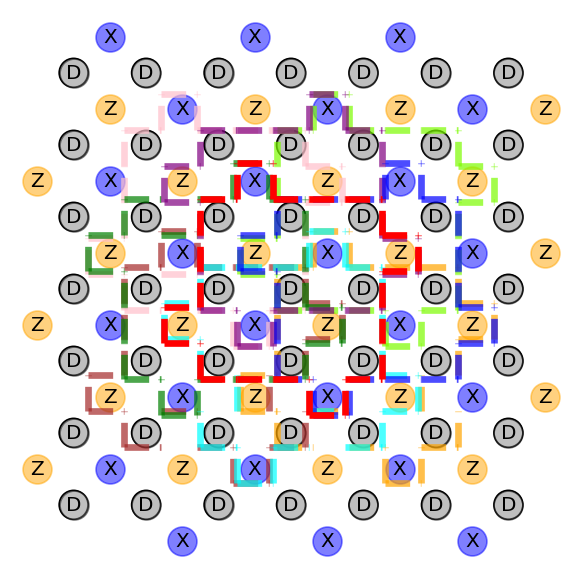

In [9]:
d = 7
measure_qubits_ord_dxd = get_measure_qubits_ord(d)
data_qubits_ord_dxd = get_data_qubits_ord(d)

kernels=[]

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 3, 3)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'orange', 'alpha':0.7, 'offset':[0.1,0.1]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 1)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'pink', 'alpha':0.7, 'offset':[-0.1,-0.1]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 3, 1)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'lawngreen', 'alpha':0.7, 'offset':[0.1,-0.1]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 3)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'brown', 'alpha':0.7, 'offset':[-0.1,0.1]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 2)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'green', 'alpha':0.7, 'offset':[-0.1,0.]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 2, 1)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'purple', 'alpha':0.7, 'offset':[0.,-0.1]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 2, 3)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'cyan', 'alpha':0.7, 'offset':[0.,0.1]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 3, 2)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'blue', 'alpha':0.7, 'offset':[0.1,0.]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 2, 2)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'red', 'alpha':1.})

plot_qubits(
  data_qubits_ord_dxd, measure_qubits_ord_dxd, d, kernels, point_size=300, save = 'd7_q25_kernels.pdf'
)

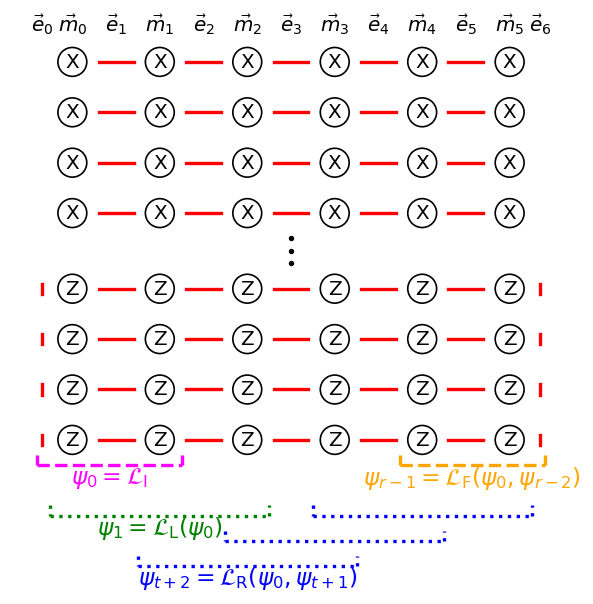

In [10]:
def plot_RCNN_layer_progression(d, r, save=None):
  na = d**2-1

  points_stabilizer = [ (x, y) for y in range(na//2) for x in range(r) ]
  points_etc = [ ((r-1)/2, points_stabilizer[-1][1] + 0.5 + 0.25*y) for y in range(3) ]
  points_stabilizer.extend([ (x, y + points_etc[-1][1] + 0.5) for y in range(na//2) for x in range(r) ])
  lines_detector = [ (-0.35, y-0.1, -0.35, y+0.1) for y in range(na//2) ]
  lines_detector.extend([ (x+0.3, y, x+0.7, y) for y in range(na//2) for x in range(r-1)  ])
  lines_detector.extend([ (x+0.3, y + points_etc[-1][1] + 0.5, x+0.7, y + points_etc[-1][1] + 0.5) for y in range(na//2) for x in range(r-1)  ])
  lines_detector.extend([ (r-1+0.35, y-0.1, r-1+0.35, y+0.1) for y in range(na//2) ])
  dxbrf = 0.4
  dxbrl = 0.25
  dybr = 0.2
  y0br = -0.3
  yoffsetbr = 1.
  bracket = {
    'points' : [
      [-dxbrl, y0br, -dxbrl, y0br-dybr],
      [-dxbrl, y0br-dybr, 2+dxbrl, y0br-dybr],
      [2+dxbrl, y0br-dybr, 2+dxbrl, y0br]
    ],
    'color' : 'black',
    'style' : '--'
  }
  brackets = [ deepcopy(bracket) for _ in range(r) ]
  brackets[0]['color'] = 'magenta'
  brackets[0]['points'] = [
    [-dxbrf, y0br, -dxbrf, y0br-dybr],
    [-dxbrf, y0br-dybr, 1+dxbrl, y0br-dybr],
    [1+dxbrl, y0br-dybr, 1+dxbrl, y0br]
  ]
  brackets[1]['color'] = 'green'
  brackets[1]['style'] = ':'
  for lb in brackets[1]['points']:
    lb[1] -= yoffsetbr
    lb[3] -= yoffsetbr
  for ibr in range(2, r-1):
    brackets[ibr]['color'] = 'blue'
    brackets[ibr]['style'] = ':'
    for lb in brackets[ibr]['points']:
      lb[0] += ibr-1
      lb[2] += ibr-1
      lb[1] -= yoffsetbr*(r-2-ibr)/2 + yoffsetbr
      lb[3] -= yoffsetbr*(r-2-ibr)/2 + yoffsetbr
  brackets[r-1]['color'] = 'orange'
  brackets[r-1]['points'] = [
    [r-2-dxbrl, y0br, r-2-dxbrl, y0br-dybr],
    [r-2-dxbrl, y0br-dybr, r-1+dxbrf, y0br-dybr],
    [r-1+dxbrf, y0br-dybr, r-1+dxbrf, y0br]
  ]

  ymlabel = None

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.scatter([x for x, _ in points_stabilizer], [y for _, y in points_stabilizer], s=300, marker='o', facecolors='none', edgecolors='black')
  ax.scatter([x for x, _ in points_etc], [y for _, y in points_etc], s=5, marker='o', facecolors='black', edgecolors='black')
  for ips, ps in enumerate(points_stabilizer):
    x, y = ps
    if y<na//2:
      ax.text(x, y, 'Z', fontsize=12, color='black', ha='center', va='center')
    else:
      ax.text(x, y, 'X', fontsize=12, color='black', ha='center', va='center')
    if ips>=(r-1)*na+2:
      idx = ips-2-(r-1)*na
      ymlabel = y + 0.75
      ax.text(x, ymlabel, f'$\\vec{{m}}_{idx}$', fontsize=12, color='black', ha='center', va='center')
  
  for lp in lines_detector:
    ax.plot([lp[0], lp[2]], [lp[1], lp[3]], linestyle='-', linewidth=2, color='red')

  for ild in range(r-1):
    ax.text(ild+0.5, ymlabel, f'$\\vec{{e}}_{ild+1}$', fontsize=12, color='black', ha='center', va='center')
  ax.text(-0.35, ymlabel, '$\\vec{{e}}_0$', fontsize=12, color='black', ha='center', va='center')
  ax.text(r-1+0.35, ymlabel, f'$\\vec{{e}}_{r}$', fontsize=12, color='black', ha='center', va='center')

  for ibb, bb in enumerate(brackets):
    for ilb, lb in enumerate(bb['points']):
      ax.plot([lb[0], lb[2]], [lb[1], lb[3]], linestyle=bb['style'], linewidth=2, color=bb['color'])
      if ilb==1:
        xt = (lb[0]+lb[2])/2
        yt = (lb[1]+lb[3])/2 - yoffsetbr/4
        layer_label = None
        if ibb == 0:
          layer_label = r"$\psi_{0}=\mathcal{L}_\text{I}$"
        elif ibb == 1:
          layer_label = r"$\psi_{1}=\mathcal{L}_\text{L}(\psi_{0})$"
        elif ibb == 2:
          layer_label = r"$\psi_{t+2}=\mathcal{L}_\text{R}(\psi_{0}, \psi_{t+1})$"
        elif ibb == r-1:
          layer_label = r"$\psi_{r-1}=\mathcal{L}_\text{F}(\psi_{0}, \psi_{r-2})$"
        if layer_label is not None:
          ax.text(xt, yt, layer_label, fontsize=14, color=bb['color'], ha='center', va='center')
  
  fig.set_dpi(120)
  plt.grid(False)
  plt.axis('off')
  plt.show()
  if save is not None:
    fig.savefig('plots/' + save, bbox_inches="tight")


plot_RCNN_layer_progression(3, 6, save='RCNN_layer_progression_d3_r6.pdf')

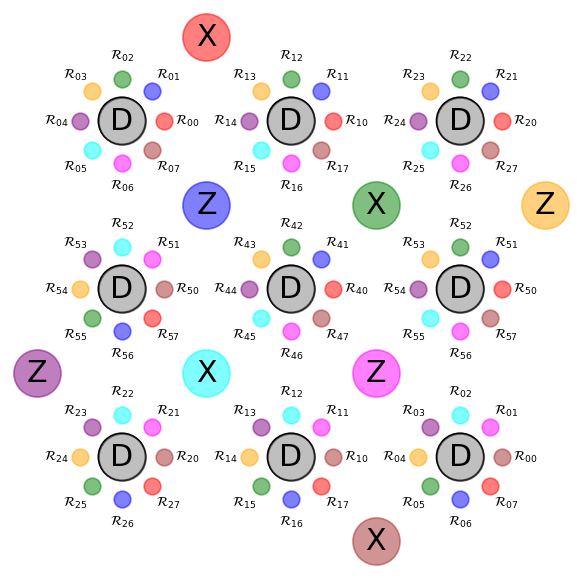

In [11]:
def plot_symkernel_output_relation(save=None):
  k=3
  point_size = 800
  measure = get_measure_qubits_ord(k)
  measure.sort()
  data = get_data_qubits_ord(k)
  data.sort()
  colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']

  arr_data = []
  arr_measure = []
  idxs_Z = []
  idxs_X = []

  for q in data:
    coords = q[2]
    x = coords[0]
    y = 2*d - coords[1]
    arr_data.append([x, y])
  for q in measure:
    coords = q[2]
    x = coords[0]
    y = 2*d - coords[1]
    lbl = q[1]
    if lbl=="M:Z":
      idxs_Z.append(len(arr_measure))
    else:
      idxs_X.append(len(arr_measure))
    arr_measure.append([x, y])

  arr_data = np.array(arr_data)
  arr_measure = np.array(arr_measure)

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.scatter(arr_data[:,0], arr_data[:,1], s=point_size, marker='o', facecolors='none', edgecolors='black')
  ax.scatter(arr_data[:,0], arr_data[:,1], s=point_size, marker='o', facecolors='gray', edgecolors='black', alpha=0.5)
  for iq in range(arr_data.shape[0]):
    ax.text(arr_data[iq, 0], arr_data[iq, 1], 'D', fontsize=18, color='black', ha='center', va='center')
  for im in range(arr_measure.shape[0]):
    ax.scatter(arr_measure[im,0], arr_measure[im,1], s=point_size, marker='o', facecolors=colors[im], edgecolors=colors[im], alpha=0.5)
    if im in idxs_Z:
      ax.text(arr_measure[im, 0], arr_measure[im, 1], 'Z', fontsize=18, color='black', ha='center', va='center')
    else:
      ax.text(arr_measure[im, 0], arr_measure[im, 1], 'X', fontsize=18, color='black', ha='center', va='center')
    for iq in range(arr_data.shape[0]):
      x = arr_data[iq,0]
      y = arr_data[iq,1]

      swap = (iq==3 or iq>=6)
      jq = iq if not swap else 8-iq
      jm = im if not swap else 7-im
      angle = jm*2*np.pi/arr_measure.shape[0]
      
      ax.scatter(x+0.5*np.cos(angle), y+0.5*np.sin(angle), color=colors[im], marker='o', s=point_size//8, facecolors=colors[im], edgecolors=colors[im], alpha=0.5)
      ax.text(x+0.775*np.cos(angle), y+0.775*np.sin(angle), f'$\\mathcal{{R}}_{{{jq}{jm}}}$', fontsize=8, color='black', ha='center', va='center')
      #ax.scatter(x+0.765*np.cos(angle), y+0.765*np.sin(angle), color=colors[im], marker='o', s=point_size//8, facecolors=colors[im], edgecolors=colors[im], alpha=0.5)
      #ax.text(x+0.5*np.cos(angle), y+0.5*np.sin(angle), f'$\\mathcal{{R}}_{{{jq}{jm}}}$', fontsize=8, color='black', ha='center', va='center')

  fig.set_dpi(120)
  plt.grid(False)
  plt.axis('off')
  plt.show()
  if save is not None:
    fig.savefig('plots/' + save, bbox_inches="tight")

plot_symkernel_output_relation("symmetric_kernel_output_relation.pdf")